# Indian Institute of Technolgy, Ropar
# B. Tech Project
## Prediction of costs for EV charging
### Team Members
* Yash Jain - 2019EEB1208
* Swapnil Saurav - 2019EEB1204
* Aishwarya Pal - 2019EEB1136

Under the Guidance of Dr. K. R. Sekhar and Nikhil.

Department of Electrical Engineering.

The overall Project is broken into subparts as follows:
1. Prediction of Irradiance from current weather data.
2. Prediction of Power from Irradiance and Temperature.
3. Estimation of cost of EV charging from grid and solar power availability.

We have used ML for the first two parts. 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install timezonefinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00
  Created wheel for timezonefinder: filename=timezonefinder-6.2.0-cp310-cp310-manylinux_2_31_x86_64.whl size=46903672 sha256=7d842f25b66cc627b4d018ce39cbd3f9e1428981bb93cfc77b1bf2af7bee58b9
  Stored in directory: /root/.cache/pip/wheels/17/19/d4/ae94459b7f74f7e8f171862d1c08adedf9b7c76ddfc514a620
Successfully built timezonefinder


In [3]:
# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
from pytz import timezone
import timezonefinder

# for saving model
from joblib import Parallel, delayed
import joblib

In [5]:
# loading the datasets
root = "/content/gdrive/MyDrive/BTP sem7 Group 2/ropar_model/"

# root = '/content/gdrive/MyDrive/App_data/Copy of '

matdata = pd.read_csv(root + "matdata.csv")
ropardata = pd.read_csv(root + "ropar_data_final.csv")

<Axes: >

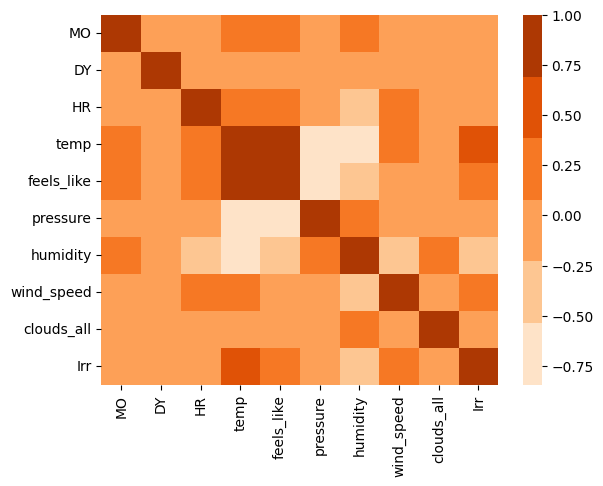

In [6]:
correlation = ropardata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

<Axes: >

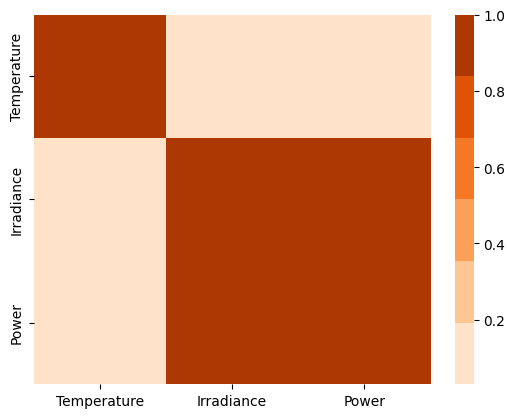

In [7]:

correlation = matdata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [8]:
# The below function will create the model, split the data, fit the model and checks the accuracies.
def model_maker(data,key):
    # creating the model.
    regressor = ExtraTreesRegressor(n_estimators = 20)

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)

    
    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.legend(["Actual Data", "Predicted Data"])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor


--------------------------------------------------

From Training Data:
r2 = 0.994413549385342

From Testing Data:
explained variance = 0.9955565545820237
mse = 462.19794134365355
r2 = 0.9955532240501587


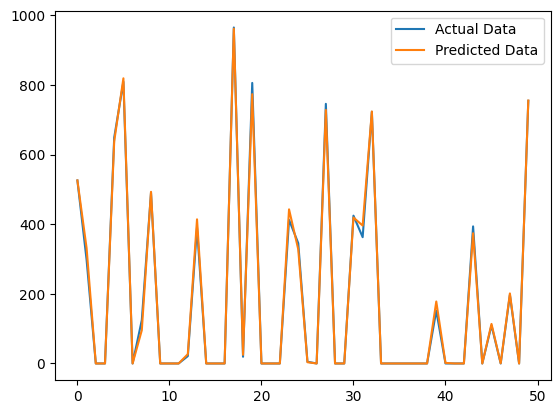


--------------------------------------------------


--------------------------------------------------

From Training Data:
r2 = 0.9622642882415791

From Testing Data:
explained variance = 0.9990556188044976
mse = 9.720204163200123
r2 = 0.9989865331778778


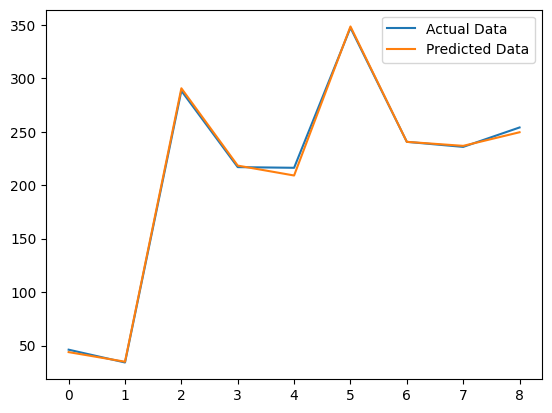


--------------------------------------------------



In [9]:
# creating the models for irradiance and voltage.
roparmodel = model_maker(ropardata,'Irr')

matmodel = model_maker(matdata,'Power')

In [10]:
# joblib.dump(roparmodel, root + 'ropar_model.pkl')
# joblib.dump(matmodel, root + 'matlab_model.pkl')

In [11]:
# The below function handles the API call.
def API_handler(lat=30.9688367,lon=76.526088):

    tf = timezonefinder.TimezoneFinder()
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)
    dd = datetime.now(timezone(timezone_str))
    month = dd.month
    day = dd.day
    hour = dd.hour

    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid=2865c640108f7ea2169c32049fb48227"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()
    # print(json.dumps(fetched_data, indent = 3))

    temp = fetched_data['main']['temp']
    feels_like = fetched_data['main']['feels_like']
    pressure = fetched_data['main']['pressure']
    humidity = fetched_data['main']['humidity']
    wind_speed = fetched_data['wind']['speed']
    clouds = fetched_data['clouds']['all']

    api_data = np.array([[month,day, hour, temp, feels_like, pressure, humidity, wind_speed, clouds]])

    print(f"Month: {api_data[0][0]} \nDay: {api_data[0][1]} \nhour: {api_data[0][2]}")
    print(f"Temperature: {api_data[0][3]} \nFeels_Like: {api_data[0][4]} \nPressure: {api_data[0][5]}")
    print(f"Humidity: {api_data[0][6]} \nWind Speed: {api_data[0][7]} \nClouds: {api_data[0][8]}")

    return api_data

# below function makes arrays of power and irradiance using the api data
def api_arr_maker(api_data):
    
    # Predict Irradiance
    irr_arr = []
    curr_time = api_data[0][2]
    for i in range(13):
        api_data[0][2] = curr_time + 1/4*i
        irr = roparmodel.predict(api_data)
        irr_arr.append(irr[0])

    pow_arr = []
    for i in range(13):
        x = [[api_data[0][3]-273.15, irr_arr[i]]]

        pow = matmodel.predict(x)
        pow_arr.append(pow[0])

    # print("irr_arr:", irr_arr)
    # print("pow_arr:", pow_arr)

    return irr_arr, pow_arr


In [12]:
# num_panels = 10
# P_grid = 10
# B_total = 40
# rate_solar = 5
# rate_grid = 200
# fixed_cost = 100000
# n_transactions = 10000
# alpha = 0.2                 # from 0-1
# beta = 0.5                  # from 0-1
# prebook_category = 3        # from 1-5
# prebooking_cost = 20
# priority_rating = 2         # from 0-5
# priority_cost = 50
# profit_margin = 0.1         # from 0-1

class cost_model:
    def __init__(self, pow_arr, num_panels = 10, P_grid = 10, B_total = 40, rate_solar = 4, rate_grid = 200, fixed_cost = 1e6, n_transactions = 5e4, 
                 prebooking_cost = 50, max_prebooking_categ = 5, priority_cost = 80, max_priority_rating = 5, profit_margin = 0.1):
        self.num_panels = num_panels
        self.P_grid = P_grid
        self.B_total = B_total
        self.rate_solar = rate_solar
        self.rate_grid = rate_grid
        self.pow_arr = pow_arr
        self.B_req = B_total*0.3
        self.t_solar_opt = 0
        self.t_ch = 0
        self.alpha = 0.4
        self.fixed_cost = fixed_cost
        self.n_transactions = n_transactions
        self.cost = 0
        self.prebooking_category = 2
        self.prebooking_cost = prebooking_cost
        self.max_prebooking_categ = max_prebooking_categ
        self.priority_rating = 2
        self.priority_cost = priority_cost
        self.max_priority_rating = max_priority_rating
        self.profit_margin = profit_margin
        self.rate_solar_rush = np.exp(self.alpha)*self.rate_solar
        

    # below function plots cost for various percentage of battery and duration.
    def cost_t_solar_plotter(self):
        figure, axis = plt.subplots(5, 4, figsize = (16,16))
        figure.tight_layout(pad=2.0)
        for perc in range (10,101,10):
            frac=perc/100
            B_req = frac*self.B_total
            t_solar_arr = []
            t_ch_arr = []
            cost_arr = []
            cost_rush_arr = []
            min_cost = 1e9
            min_time_solar = 0

            min_cost_rush = 1e9
            min_time_solar_rush = 0
            for i in range(13):
                t_solar = 1/4*i
                E_solar = 0
                prev_energy = 0
                for j in range(i):
                    P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                    E_solar += 1/4 * P_solar_t
                    if(E_solar>=B_req):
                        t_solar = (B_req-prev_energy)/P_solar_t + 1/4*j
                        E_solar = B_req
                        break
                    prev = E_solar
                E_grid = B_req - E_solar
                t_grid = E_grid/self.P_grid
                t_ch = t_solar + t_grid
                cost = t_solar*self.rate_solar + t_grid*self.rate_grid
                cost_rush = t_solar*self.rate_solar_rush + t_grid*self.rate_grid
                cost_rush_arr.append(cost_rush)
                t_solar_arr.append(t_solar)
                t_ch_arr.append(t_ch)
                cost_arr.append(cost)
                if cost < min_cost:
                  min_cost = cost
                  min_time = t_ch
                  min_time_solar = t_solar

                if cost_rush < min_cost_rush:
                  min_cost_rush = cost_rush
                  min_time_rush = t_ch
                  min_time_rush_solar = t_solar

            
            row_num = perc//21
            col_num = ((perc-row_num*20)-10)//5
            axis[row_num][col_num].plot(t_solar_arr,cost_arr, label = 'alpha = 0')
            axis[row_num][col_num].plot(t_solar_arr,cost_rush_arr, label = f'alpha = {self.alpha}')
            axis[row_num][col_num].plot(min_time_rush_solar, min_cost_rush, 'g*')
            axis[row_num][col_num].plot(min_time_solar, min_cost, 'g*')
            axis[row_num][col_num].text(min_time_solar, min_cost, round(min_time_solar,2), size=8)
            axis[row_num][col_num].text(min_time_rush_solar, min_cost_rush, round(min_time_rush_solar,2), size=8)
            axis[row_num][col_num].set_title(f'cost vs t_solar (for {perc}% of Battery)')
            axis[row_num][col_num].legend()

            axis[row_num][col_num + 1].plot(t_ch_arr,cost_arr, label = 'alpha = 0')
            axis[row_num][col_num + 1].plot(t_ch_arr,cost_rush_arr, label = f'alpha = {self.alpha}')
            axis[row_num][col_num + 1].plot(min_time_rush, min_cost_rush, 'g*')
            axis[row_num][col_num + 1].plot(min_time, min_cost, 'g*')
            axis[row_num][col_num + 1].text(min_time, min_cost, round(min_time,2), size=8)
            axis[row_num][col_num + 1].text(min_time_rush, min_cost_rush, round(min_time_rush,2), size=8)
            axis[row_num][col_num + 1].set_title(f'cost vs t_ch (for {perc}% of Battery)')
            axis[row_num][col_num + 1].legend()


        figure.savefig(root+'t_solar_plots_final.png', dpi=600)

    def base_cost_finder(self):
        self.cost = float('inf')
        self.t_solar_opt = 0
        for i in range(13):
            t_solar = 1/4*i
            E_solar = 0
            prev_energy = 0
            for j in range(i):
                P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                E_solar += 1/4 * P_solar_t
                if(E_solar>=self.B_req):
                    t_solar = (self.B_req-prev_energy)/P_solar_t + 1/4*j
                    E_solar = self.B_req
                    break
                prev = E_solar
            E_grid = self.B_req - E_solar
            t_grid = E_grid/self.P_grid
            t_ch = t_solar + t_grid
            cost = t_solar*self.rate_solar + t_grid*self.rate_grid
            if(cost<self.cost):
                self.cost = cost
                self.t_solar_opt = t_solar
                self.t_ch = t_ch
        self.cost = round(self.cost,2)
        self.t_solar_opt = round(self.t_solar_opt,2)
        self.t_ch = round(self.t_ch,2)

    def rush_factor(self):
        self.rate_solar_rush = np.exp(self.alpha)*self.rate_solar
        self.cost = float('inf')
        self.t_solar_opt = 0
        for i in range(13):
            t_solar = 1/4*i
            E_solar = 0
            prev_energy = 0
            for j in range(i):
                P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                E_solar += 1/4 * P_solar_t
                if(E_solar>=self.B_req):
                    t_solar = (self.B_req-prev_energy)/P_solar_t + 1/4*j
                    E_solar = self.B_req
                    break
                prev = E_solar
            E_grid = self.B_req - E_solar
            t_grid = E_grid/self.P_grid
            t_ch = t_solar + t_grid
            cost = t_solar*self.rate_solar_rush + t_grid*self.rate_grid
            if(cost<self.cost):
                self.cost = cost
                self.t_solar_opt = t_solar
                self.t_ch = t_ch
        self.cost = round(self.cost,2)
        self.t_solar_opt = round(self.t_solar_opt,2)
        self.t_ch = round(self.t_ch,2)

    def fixed_cost_factor(self):
        self.cost = self.cost + self.fixed_cost/self.n_transactions
        self.cost = round(self.cost,2)

    def prebooking_factor(self):
        self.cost = self.cost - self.prebooking_category*self.prebooking_cost/self.max_prebooking_categ
        self.cost = round(self.cost,2)

    def priority_factor(self):
        self.cost = self.cost + self.priority_rating*self.priority_cost/self.max_priority_rating
        self.cost = round(self.cost,2)

    def profit_factor(self):
        self.cost = self.cost*(1+self.profit_margin)
        self.cost = round(self.cost,2)

    def cost_calculator(self, alpha = 0.4, prebooking_category = 2, priority_rating = 2):
        print(f'alpha = {alpha}, prebooking_category = {prebooking_category}, priority_rating = {priority_rating}')
        self.alpha = alpha
        self.prebooking_category = prebooking_category
        self.priority_rating = priority_rating
        self.base_cost_finder()
        print(f'base cost = {self.cost}, solar charging time = {self.t_solar_opt}, total_charging_time = {self.t_ch}')
        self.rush_factor()
        print(f'cost after rush factor = {self.cost}, solar charging time = {self.t_solar_opt}, total charging time = {self.t_ch}')
        self.fixed_cost_factor()
        print(f'cost after fixed cost factor = {self.cost}')
        self.prebooking_factor()
        print(f'cost after prebooking factor = {self.cost}')
        self.priority_factor()
        print(f'cost after priority factor = {self.cost}')
        self.profit_factor()
        print(f'cost after profit factor = {self.cost}')

        print(f'FINAL COST = {self.cost}, SOLAR CHARGING TIME = {self.t_solar_opt}, TOTAL CHARGING TIME = {self.t_ch}')


Sucessfully fetched the data from the API.
Month: 5.0 
Day: 11.0 
hour: 15.0
Temperature: 312.29 
Feels_Like: 308.86 
Pressure: 1005.0
Humidity: 6.0 
Wind Speed: 2.72 
Clouds: 0.0
alpha = 0.4, prebooking_category = 2, priority_rating = 2
base cost = 209.48, solar charging time = 2.75, total_charging_time = 3.74
cost after rush factor = 214.32, solar charging time = 2.25, total charging time = 3.25
cost after fixed cost factor = 234.32
cost after prebooking factor = 214.32
cost after priority factor = 246.32
cost after profit factor = 270.95
FINAL COST = 270.95, SOLAR CHARGING TIME = 2.25, TOTAL CHARGING TIME = 3.25


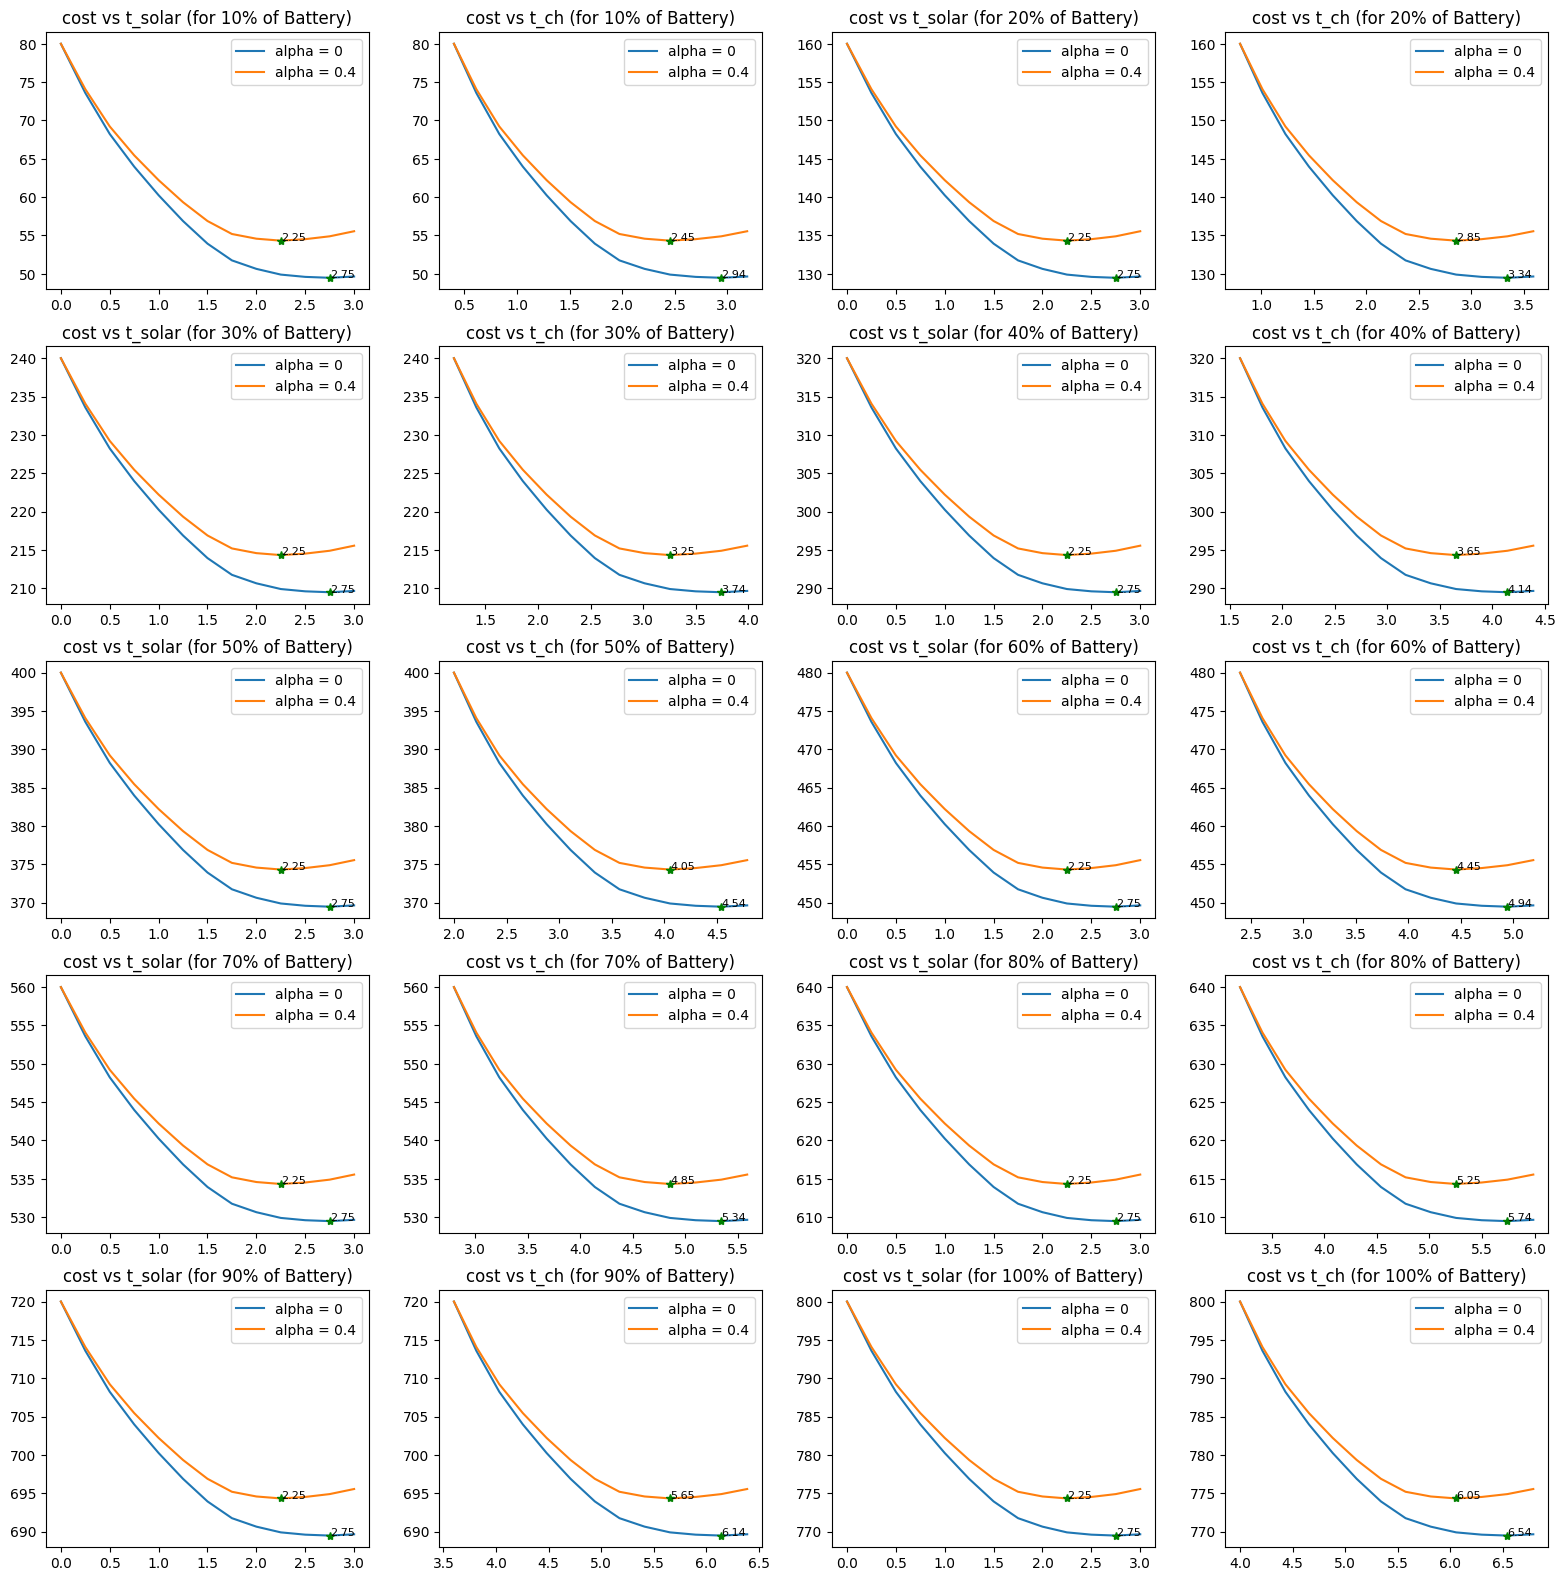

In [13]:

api_data = API_handler()
# api_data[0][2] = 16
irr_arr, pow_arr = api_arr_maker(api_data)
c_model = cost_model(pow_arr)
c_model.cost_t_solar_plotter()
c_model.cost_calculator(alpha=0.4)

alpha = 0.0, prebooking_category = 2, priority_rating = 2
base cost = 209.48, solar charging time = 2.75, total_charging_time = 3.74
cost after rush factor = 209.48, solar charging time = 2.75, total charging time = 3.74
cost after fixed cost factor = 229.48
cost after prebooking factor = 209.48
cost after priority factor = 241.48
cost after profit factor = 265.63
FINAL COST = 265.63, SOLAR CHARGING TIME = 2.75, TOTAL CHARGING TIME = 3.74
alpha = 0.1, prebooking_category = 2, priority_rating = 2
base cost = 209.48, solar charging time = 2.75, total_charging_time = 3.74
cost after rush factor = 210.64, solar charging time = 2.75, total charging time = 3.74
cost after fixed cost factor = 230.64
cost after prebooking factor = 210.64
cost after priority factor = 242.64
cost after profit factor = 266.9
FINAL COST = 266.9, SOLAR CHARGING TIME = 2.75, TOTAL CHARGING TIME = 3.74
alpha = 0.2, prebooking_category = 2, priority_rating = 2
base cost = 209.48, solar charging time = 2.75, total_char

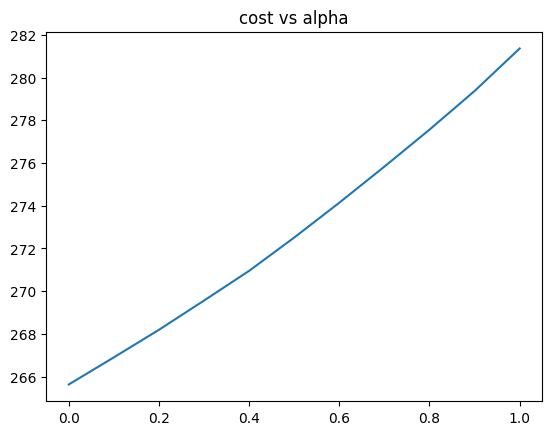

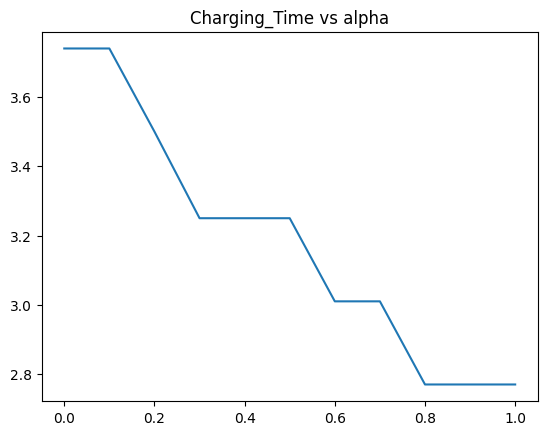

In [14]:
alphas = np.array(range(11))/10
cost_array_alpha = []
time_array_alpha = []

for alpha in alphas:
    c_model.cost_calculator(alpha=alpha)
    cost_array_alpha.append(c_model.cost)
    time_array_alpha.append(c_model.t_ch)

plt.plot(alphas,cost_array_alpha)
plt.title('cost vs alpha')
plt.savefig('cost_alpha',dpi = 600)
plt.show()


plt.plot(alphas, time_array_alpha)
plt.title('Charging_Time vs alpha')
plt.savefig('charge_time_alpha', dpi = 600)
plt.show()